# Databases and Datamining Assignment 3

Written by Lucas van Dijk

## Abstract

In this report we try to find relations and association rules in the adult data set, and we will focus on education and occupation, and what that means for your chance to get an income higher than 50K a year.

## Data Preparation

We start by importing the necessary Python packages. Pandas is a very popular Python data analysis library, Matplotlib is the de facto plotting library for Python, and seaborn is a layer on top of Matplotlib, providing integration between pandas and Matplotlib, and includes several useful statistical analysis plots.

I also have written some python modules myself, which provides functionality for mining frequent patterns and association rules, plus measures for evaluating these rules.

In [1]:
%matplotlib inline
import warnings

# Third party packages/modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Our own modules
from dbdm import itemsets, rules, measures, util

# Disable warnings and configure seaborn plots
warnings.filterwarnings('ignore')
sns.set()


/usr/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


Next, we want to read the dataset from the CSV file. Pandas provides a nice convenience function for that. We specify the the column names and the value used in the case when data is missing. We store the data in a variable called `df`. We also don't need the `fnlwgt` and `education_num` column, so we remove these from the dataset.

In [2]:
# Read the adult dataset
df = pd.read_csv(
    "data/adult.data",
    engine='c',
    lineterminator='\n',

    names=['age', 'workclass', 'fnlwgt', 'education', 'education_num',
           'marital_status', 'occupation', 'relationship', 'race', 'sex',
           'capital_gain', 'capital_loss', 'hours_per_week',
           'native_country', 'income'],
    header=None,
    skipinitialspace=True,
    na_values="?"
)

# Remove fnlwgt column and education num column
df = df[['age', 'workclass', 'education', 'marital_status',
         'occupation', 'relationship', 'race', 'sex', 'capital_gain',
         'capital_loss', 'hours_per_week', 'native_country', 'income']]



Currently, the `education` and `income` fields do not have an order defined yet. While they're catogorical data, their values definitely have an implicit order, for example a Masters degree is higher than a Bachelors degree. We make sure our Pandas dataset knows about this order in the code snippet below.

In [3]:
# Transform education to ordered categorical data
# Preschool < 1st-4th < 5th-6th < 7th-8th < 9th < 10th < 11th < 12th
# < HS-grad < Prof-school < Assoc-acdm < Assoc-voc < Some-college 
# < Bachelors < Masters < Doctorate.
df['education'] = df['education'].astype("category", categories=[
        'Preschool',
        '1st-4th',
        '5th-6th',
        '7th-8th',
        '9th',
        '10th',
        '11th',
        '12th',
        'HS-grad',
        'Prof-school',
        'Assoc-acdm',
        'Assoc-voc',
        'Some-college',
        'Bachelors',
        'Masters',
        'Doctorate'        
    ])

# Transform income to ordered categorical type
df['income'] = df['income'].astype("category", categories=["<=50K", ">50K"])

The fields `age`, `capitcal_gain`, `capital_loss` and `hours_per_week` are continuous variables, but for plotting and frequent pattern mining it would be more useful if there is also a binned version of these variables, which we create below.

In [4]:
# Predefined bins for age and hours per week
age_bins = [0, 20, 30, 40, 50, 60, 80, 100, 150]
hours_per_week_bins = [0, 10, 20, 30, 40, 50, 60, 70, 100]

df['age_binned'] = pd.cut(df['age'], bins=age_bins)
df['hours_per_week_binned'] = pd.cut(df['hours_per_week'], bins=hours_per_week_bins)

# Equal frequency bins for capital loss and gain
labels = ['Very low', 'Low', 'High', 'Very high']
df['capital_loss_binned'] = pd.cut(df['capital_loss'], bins=500)
df['capital_gain_binned'] = pd.cut(df['capital_gain'], bins=500)

## Data Exploration

In this section we will take a bit closer look at the data, by reviewing some statistical features, distributions of certain variables and more.

### Statistical features

In [5]:
df.describe()

,age,capital_gain,capital_loss,hours_per_week
count,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1077.648844,87.303830,40.437456
std,13.640433,7385.292085,402.960219,12.347429
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


In [6]:
# Split dataframe to limit the width of the table
df.iloc[:, 0:10].describe(include=['O', 'category'])

,workclass,education,marital_status,occupation,relationship,race,sex
count,30725,32561,32561,30718,32561,32561,32561
unique,8,16,7,14,6,5,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male
freq,22696,10501,14976,4140,13193,27816,21790


In [7]:
df.iloc[:, 10:].describe(include=['O', 'category'])

,native_country,income,age_binned,hours_per_week_binned,capital_loss_binned,capital_gain_binned
count,31978,32561,32561,32561,32561,32561
unique,41,2,7,8,79,54
top,United-States,<=50K,"(30, 40]","(30, 40]","(-4.356, 8.712]","(-99.999, 199.998]"
freq,29170,24720,8546,17735,31042,29855


In [8]:
# The number of people earning less and more than 50K
print(len(df[df['income'] == "<=50K"]))
print(len(df[df['income'] == ">50K"]))

24720
7841


So there are a lot more people earning less than 50K per year.

### Distributions

To get some sense how certain variables are distributed, we plot several violin plots, which combines a boxplot with kernel density estimation.

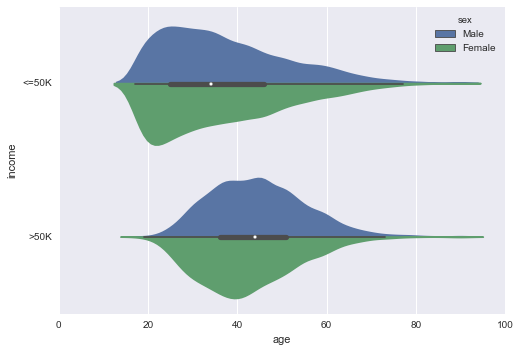

In [9]:
p = sns.violinplot(x="age", y="income", hue="sex", split=True, data=df)

You can see that people who earn more than 50K per year are a bit older on average.

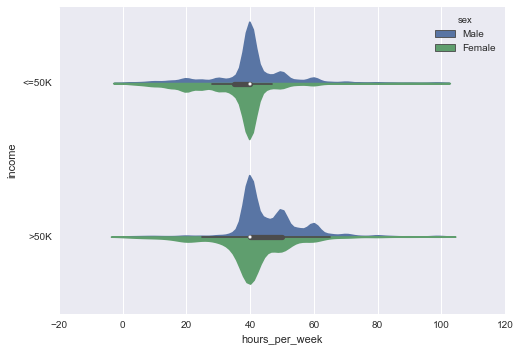

In [10]:
p = sns.violinplot(x="hours_per_week", y="income", hue="sex", split=True, data=df)

It's not really strange that median for both people with a salary below and above 50K is 40 hours per week, because a five day workweek is very common. You can also see that especially men which earn more than 50K often work more than 40 hours per week.

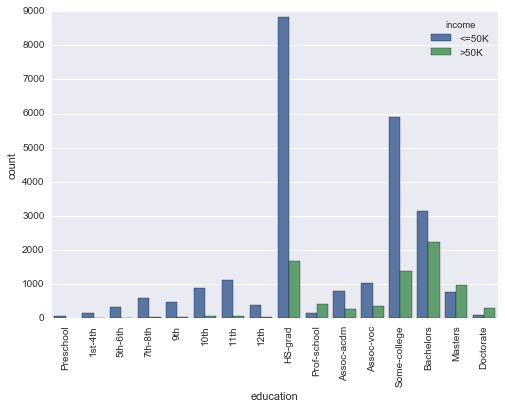

In [11]:
p = sns.countplot(x="education", hue="income", data=df)
plt.setp(p.get_xticklabels(), rotation=90)  # Rotate labels
p

## Frequent patterns

In this section we'll be using the FP-growth algorithm to mine for frequent patterns. We'll consider the people earning more than 50K and less or equal than 50K separate, because of their skewed distributions.

In [16]:
# Define the required configuration and datasets
MIN_SUPPORT = 10
MIN_CONFIDENCE = 60

# Only use subset of the fields
subset_fields = [
    'age_binned', 'education', 'workclass', 'relationship',
    'occupation', 'hours_per_week_binned'
]

df_higher_50k = df[df['income'] == ">50K"]
df_higher_50k = df_higher_50k[subset_fields]

df_lower_50k = df[df['income'] == "<=50K"]
df_lower_50k = df_lower_50k[subset_fields]

### More than 50K

In [17]:
assoc_rules = rules.generate_association_rules(
    df_higher_50k,
    MIN_SUPPORT,
    MIN_CONFIDENCE
)

for a, b in assoc_rules:
    print(util.format_rule(a, b))
    print("-"*60)
    print("Measures:")
    
    supports = measures.calculate_supports(df_higher_50k, a, b)
    print("- support", supports['ab'], 
          str(round((supports['ab'] * 100)/len(df_higher_50k)))+"%")
    
    for measure, value in measures.calculate(df_higher_50k, a, b, supports).items():
        print("-", measure, value)
        
    print()

{occupation: Sales} => {relationship: Husband}
------------------------------------------------------------
Measures:
- support 786 10%
- lift 0.00013511204501534535
- max_confidence 0.13281514025008448
- all_confidence 0.13281514025008448
- confidence 0.7995930824008138
- imbalance_ratio 0.8070318887980377
- cosine 0.325880449524149
- kulczynski 0.13281514025008448

{workclass: Private} => {relationship: Husband}
------------------------------------------------------------
Measures:
- support 3753 48%
- lift 0.00012777895391765916
- max_confidence 0.6341669482933423
- all_confidence 0.6341669482933423
- confidence 0.7561958492847068
- imbalance_ratio 0.1339786756453423
- cosine 0.6924986744052113
- kulczynski 0.6341669482933423

{relationship: Husband} => {workclass: Private}
------------------------------------------------------------
Measures:
- support 3753 48%
- lift 0.00012777895391765916
- max_confidence 0.7561958492847068
- all_confidence 0.6341669482933423
- confidence 0.63416

### Less than 50K

In [15]:
assoc_rules = rules.generate_association_rules(
    df_lower_50k,
    MIN_SUPPORT,
    MIN_CONFIDENCE
)

for a, b in assoc_rules:
    print(util.format_rule(a, b))
    print("-"*60)
    print("Measures:")
    
    supports = measures.calculate_supports(df_lower_50k, a, b)
    print("- support", supports['ab'], 
          str(round((supports['ab'] * 100)/len(df_lower_50k)))+"%")
    
    for measure, value in measures.calculate(df_lower_50k, a, b, supports).items():
        print("-", measure, value)
        
    print()

{relationship: Unmarried} => {hours_per_week_binned: (30, 40]}
------------------------------------------------------------
Measures:
- support 2134 9%
- lift 4.6875874529407076e-05
- max_confidence 0.15131532298092604
- all_confidence 0.15131532298092604
- confidence 0.661090458488228
- imbalance_ratio 0.7156017635059552
- cosine 0.31628012306459397
- kulczynski 0.15131532298092604

{education: Bachelors} => {hours_per_week_binned: (30, 40]}
------------------------------------------------------------
Measures:
- support 1717 7%
- lift 3.8847206763658437e-05
- max_confidence 0.12174714599730554
- all_confidence 0.12174714599730554
- confidence 0.5478621569878749
- imbalance_ratio 0.7067654639175258
- cosine 0.2582646975744101
- kulczynski 0.12174714599730554

{occupation: Adm-clerical} => {workclass: Private}
------------------------------------------------------------
Measures:
- support 2512 10%
- lift 4.3413054875916e-05
- max_confidence 0.14165679806011391
- all_confidence 0.14165